# Fine-tuning: 通过微调来迁移学习


在前面的章节里我们展示了如何训练神经网络来识别小图片里的问题。我们也介绍了ImageNet这个学术界默认的数据集，它有超过一百万的图片和一千类的物体。这个数据集很大的改变计算机视觉这个领域，展示了很多事情虽然在小的数据集上做不到，但在数GB的大数据上是可能的。事实上，我们目前还不知道有什么技术可以在类似的但小图片数据集上，例如一万张图片，训练出一个同样强大的模型。

所以这是一个问题。尽管深度卷积神经网络在ImageNet上有了很惊讶的结果，但大部分人不关心Imagenet这个数据集本身。他们关心他们自己的问题。例如通过图片里面的人脸识别身份，或者识别图片里面的10种不同的珊瑚。通常大部分在非BAT类似大机构里的人在解决计算机视觉问题的时候，能获得的只是相对来说中等规模的数据。几百张图片很正常，找到几千张图片也有可能，但很难同Imagenet一样获得上百万张图片。

于是我们会有一个很自然的问题，如何使用在百万张图片上训练出来的强大的模型来帮助提升在小数据集上的精度呢？这种在源数据上训练，然后将学到的知识应用到目标数据集上的技术通常被叫做**迁移学习**。幸运的是，我们有一些有效的技术来解决这个问题。

对于深度神经网络来首，最为流行的一个方法叫做微调（fine-tuning）。它的想法很简单但有效：


* 在源数据 $S$ 上训练一个神经网络。
* 砍掉它的头，将它的输出层改成适合目标数据 $S$ 的大小
* 将输出层的权重初始化成随机值，但其它层保持跟原先训练好的权重一致
* 然后开始在目标数据集开始训练

下图图示了这个算法：

![](../img/fine-tuning.svg)

## 热狗识别

这一章我们将通过[ResNet](../chapter_convolutional-neural-networks/resnet-gluon.md)来演示如何进行微调。因为通常不会每次从0开始在ImageNet上训练模型，我们直接从Gluon的模型园下载已经训练好的。然后将其迁移到一个我们感兴趣的问题上：识别热狗。

![hot dog](../img/comic-hot-dog.png)


热狗识别是一个二分类问题。我们这里使用的热狗数据集是从网上抓取的，它有$1400$张正类和同样多的负类，负类主要是食品相关图片。我们将各类的$1000$张作为训练集合，其余的作为测试集合。

### 获取数据

我们首先从网上下载数据并解压到`../data/hotdog`。每个文件夹下会有对应的`png`文件。

In [1]:
from mxnet import gluon 
import zipfile 

data_dir='../data'
fname=gluon.utils.download(
    'https://apache-mxnet.s3-accelerate.amazonaws.com/gluon/dataset/hotdog.zip',path=data_dir
)

with zipfile.ZipFile(fname,'r') as f:
    f.extractall(data_dir) 

我们使用图片增强里类似的方法来处理图片

In [2]:
from mxnet import nd
from mxnet import image 
from mxnet import gluon 

train_augs=[
    image.HorizontalFlipAug(.5),
    image.RandomCropAug((224,224))
]
test_augs=[
    image.CenterCropAug((224,224))
]
def transform(data,label,augs):
    data=data.astype('float32') 
    for aug in augs:
        data=aug(data)
    data=nd.transpose(data,(2,0,1)) 
    return data,nd.array([label]).asscalar().astype('float32')

In [3]:
#matplotlib inline 
import matplotlib.pyplot as plt
def show_images(imgs,nrows,ncols,figsize=None):
    if not figsize:
        figsize=(ncols,nrows) 
    _,figs=plt.subplots(nrows,ncols,figsize=figsize)
    for i in range(nrows):
        for j in range(ncols):
            figs[i][j].imshow(imgs[i*ncols+j].asnumpy())
            figs[i][j].axes.get_xaxis().set_visible(False)
            figs[i][j].axes.get_yaxis().set_visible(False) 
    plt.show() 

读取文件，并画出

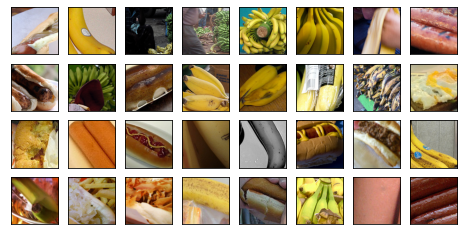

In [4]:
train_imgs=gluon.data.vision.ImageFolderDataset(
    data_dir+'/hotdog/train',
    transform=lambda X,y:transform(X,y,train_augs)
)
test_imgs=gluon.data.vision.ImageFolderDataset(
    data_dir+'/hotdog/test',
    transform=lambda X,y:transform(X,y,test_augs) 
)

data=gluon.data.DataLoader(train_imgs,32,shuffle=True)
for X,_ in data:
    X=X.transpose((0,2,3,1)).clip(0,255)/255
    show_images(X,4,8) 
    break 

In [5]:
from mxnet.gluon.model_zoo import vision as models
pretrained_net = models.resnet18_v2(pretrained=True)


通常好的训练模型由两块构成，一是feature ，而是classifier.后者主要包括最后一层全连接层，前者包含从输入开始的大部分层。这样的划分的一个主要目的是为了更方便的做微调。我们先看下classifier的内容： 

通常预训练好的模型由两块构成，一是`features`，二是`output`。后者主要包括最后一层全连接层，前者包含从输入开始的大部分层。这样的划分的一个主要目的是为了更方便做微调。我们先看下`output`的内容：


In [6]:
pretrained_net.output


Dense(512 -> 1000, linear)

我们可以看一下第一个卷积层的部分权重。


In [7]:
pretrained_net.features[1].weight.data()[0][0]



[[-1.64019989e-16 -1.64107318e-15  1.15900094e-14 -1.45087223e-14
   6.13736823e-15  9.31420553e-15 -4.96812310e-15]
 [-5.24587960e-15 -6.12600231e-15  2.52703958e-15 -1.26492343e-14
  -8.80555886e-15 -9.94531707e-15  3.19777765e-15]
 [ 6.95685058e-15  1.30257726e-14 -9.37785412e-15 -2.26256455e-15
  -1.28336622e-14 -1.03294219e-14  2.46130834e-15]
 [ 1.46163040e-14 -1.04503681e-14 -1.71437571e-14 -8.13254205e-15
  -4.71141028e-15  8.24006865e-15  3.25102235e-15]
 [ 1.74203032e-14 -1.88471827e-14 -2.52042954e-14 -3.48773736e-15
   2.85282793e-15  2.09951079e-16  6.23012214e-16]
 [-3.97822237e-15  2.91143075e-15  1.07994753e-15 -6.06272895e-15
  -8.24556759e-15  7.16038963e-15  2.21876333e-14]
 [-4.45479614e-15 -1.42962814e-15  4.07669588e-15 -9.37792633e-16
  -9.36154578e-16 -2.20163980e-15  1.13034124e-14]]
<NDArray 7x7 @cpu(0)>

在微调里，我们一般新建一个网络，它的定义跟之前训练好的网络一样，除了最后的输出数等于当前数据的类别数。新网络的`features`被初始化前面训练好网络的权重，而`output`则是从头开始训练。


In [8]:
pretrained_net.features

HybridSequential(
  (0): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=True, use_global_stats=False, in_channels=3)
  (1): Conv2D(3 -> 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
  (3): Activation(relu)
  (4): MaxPool2D(size=(3, 3), stride=(2, 2), padding=(1, 1), ceil_mode=False, global_pool=False, pool_type=max, layout=NCHW)
  (5): HybridSequential(
    (0): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv1): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm(axis=1, eps=1e-05, momentum=0.9, fix_gamma=False, use_global_stats=False, in_channels=64)
      (conv2): Conv2D(64 -> 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
    )
    (1): BasicBlockV2(
      (bn1): BatchNorm(axis=1, eps=1e-05, 

【注意】未来几天我们可能会将classifier从命名成ouput,并在里面自保留了最后的Dense.
我们可以看一下第一个卷积层的部分权重。

In [9]:
pretrained_net.features[1].params.get('weight').data()[0][0]


[[-1.64019989e-16 -1.64107318e-15  1.15900094e-14 -1.45087223e-14
   6.13736823e-15  9.31420553e-15 -4.96812310e-15]
 [-5.24587960e-15 -6.12600231e-15  2.52703958e-15 -1.26492343e-14
  -8.80555886e-15 -9.94531707e-15  3.19777765e-15]
 [ 6.95685058e-15  1.30257726e-14 -9.37785412e-15 -2.26256455e-15
  -1.28336622e-14 -1.03294219e-14  2.46130834e-15]
 [ 1.46163040e-14 -1.04503681e-14 -1.71437571e-14 -8.13254205e-15
  -4.71141028e-15  8.24006865e-15  3.25102235e-15]
 [ 1.74203032e-14 -1.88471827e-14 -2.52042954e-14 -3.48773736e-15
   2.85282793e-15  2.09951079e-16  6.23012214e-16]
 [-3.97822237e-15  2.91143075e-15  1.07994753e-15 -6.06272895e-15
  -8.24556759e-15  7.16038963e-15  2.21876333e-14]
 [-4.45479614e-15 -1.42962814e-15  4.07669588e-15 -9.37792633e-16
  -9.36154578e-16 -2.20163980e-15  1.13034124e-14]]
<NDArray 7x7 @cpu(0)>

在微调里面，我们一般建立一个网络。它的定义跟之前训练好的网络一样，除了最后的输出数等于当前数据的类别数，新网络的features被初始化前面训练好的网络权重，而classifier则是从头开训练。 

In [10]:
from mxnet import init 
finetune_net=models.resnet18_v2(classes=2) 
finetune_net.features=pretrained_net.features 
finetune_net.output.initialize(init.Xavier())

我们先定义一个可以重复使用的训练函数。


In [11]:
def train(net,ctx,batch_size=64,epochs=10,learning_rate=0.01,wd=0.001):
    train_data=gluon.data.DataLoader(train_imgs,batch_size,shuffle=True)
    test_data=gluon.data.DataLoader(test_imgs,batch_size) 
    # 确保net的初始化在ctx 上 
    net.collect_params().reset_ctx(ctx) 
    net.hybridize()  
    loss = gluon.loss.SoftmaxCrossEntropyLoss()    
    # 训练 
    trainer=gluon.Trainer(net.collect_params(),'sgd',{'learning_rate':learning_rate,'wd':wd})
    utils.train(train_data,test_data,net,loss,trainer,ctx,epochs) 

现在我们可以开始训练了：

In [12]:
import sys 
sys.path.append('..') 
import utils 
ctx=utils.try_all_gpus() 
train(finetune_net,ctx,epochs=100) 

Start training on  [gpu(0)]
Epoch 0. Loss: 0.345, Train acc 0.84, Test acc 0.92, Time 21.0 sec
Epoch 1. Loss: 0.175, Train acc 0.93, Test acc 0.93, Time 18.1 sec
Epoch 2. Loss: 0.131, Train acc 0.95, Test acc 0.93, Time 18.0 sec
Epoch 3. Loss: 0.107, Train acc 0.96, Test acc 0.95, Time 17.6 sec
Epoch 4. Loss: 0.084, Train acc 0.97, Test acc 0.94, Time 19.9 sec
Epoch 5. Loss: 0.073, Train acc 0.97, Test acc 0.95, Time 17.3 sec
Epoch 6. Loss: 0.053, Train acc 0.98, Test acc 0.94, Time 18.4 sec
Epoch 7. Loss: 0.053, Train acc 0.98, Test acc 0.96, Time 17.5 sec
Epoch 8. Loss: 0.048, Train acc 0.99, Test acc 0.95, Time 17.5 sec
Epoch 9. Loss: 0.044, Train acc 0.98, Test acc 0.95, Time 19.0 sec
Epoch 10. Loss: 0.033, Train acc 0.99, Test acc 0.95, Time 18.9 sec
Epoch 11. Loss: 0.029, Train acc 0.99, Test acc 0.94, Time 18.3 sec
Epoch 12. Loss: 0.027, Train acc 0.99, Test acc 0.95, Time 18.2 sec
Epoch 13. Loss: 0.022, Train acc 0.99, Test acc 0.96, Time 17.2 sec
Epoch 14. Loss: 0.022, Train a

对比我们尝试从随机初始值开始训练一个网络。

In [14]:
scratch_net=models.resnet18_v2(classes=2) 
scratch_net.initialize(init=init.Xavier()) 
train(scratch_net,ctx,epochs=100) 

Start training on  [gpu(0)]
Epoch 0. Loss: 0.451, Train acc 0.79, Test acc 0.75, Time 17.3 sec
Epoch 1. Loss: 0.368, Train acc 0.83, Test acc 0.83, Time 19.4 sec
Epoch 2. Loss: 0.340, Train acc 0.85, Test acc 0.84, Time 20.0 sec
Epoch 3. Loss: 0.324, Train acc 0.86, Test acc 0.82, Time 21.6 sec
Epoch 4. Loss: 0.310, Train acc 0.86, Test acc 0.81, Time 17.7 sec
Epoch 5. Loss: 0.304, Train acc 0.86, Test acc 0.70, Time 16.6 sec
Epoch 6. Loss: 0.305, Train acc 0.87, Test acc 0.78, Time 19.8 sec
Epoch 7. Loss: 0.278, Train acc 0.89, Test acc 0.77, Time 17.7 sec
Epoch 8. Loss: 0.288, Train acc 0.88, Test acc 0.84, Time 17.8 sec
Epoch 9. Loss: 0.265, Train acc 0.89, Test acc 0.82, Time 21.5 sec
Epoch 10. Loss: 0.255, Train acc 0.90, Test acc 0.83, Time 19.4 sec
Epoch 11. Loss: 0.251, Train acc 0.90, Test acc 0.72, Time 18.1 sec
Epoch 12. Loss: 0.266, Train acc 0.90, Test acc 0.71, Time 19.1 sec
Epoch 13. Loss: 0.258, Train acc 0.89, Test acc 0.82, Time 18.6 sec
Epoch 14. Loss: 0.251, Train a

可以看到，微调版本收敛比随机值开始的要快很多。
# 图片预测

In [ ]:
import matplotlib.pyplot as plt 
def classify_hotdog(net,fname):
    with open(fname,'rb') as f:
        img=image.imdecode(f.read())
    data,_=transform(img,-1,test_augs)
    plt.imshow(data.transpose((1,2,0)).asnumpy()/255) 
    data=data.expand_dims(axis=0) 
    out=net(data.as_in_context(ctx[0]))
    out=nd.SoftmaxActivation(out) 
    pred=int(nd.argmax(out,axis=1).asscalar()) 
    print('pred:',pred) 
    print('out:',out) 
    print('nd.argmax(out,axis=1)',nd.argmax(out,axis=1))
    prob=out[0][pred].asscalar()
    label=train_imgs.synsets
    return 'With prob=%f,%s'%(prob,label[pred]) 

接下来我们用训练好的图片来预测几张图片： 

In [ ]:
classify_hotdog(finetune_net,'../img/real_hotdog.jpg') 

In [ ]:
classify_hotdog(finetune_net,'../img/leg_hotdog.jpg') 

In [ ]:
classify_hotdog(finetune_net,'../img/dog_hotdog.jpg') 


## 结论

我们看到，通过一个预先训练好的模型，我们可以在即使较小的数据集上训练得到很好的分类器。这是因为这两个任务里面的数据表示有很多共通性，例如都需要如何识别纹理、形状、边等等。而这些通常被在靠近数据的层有效的处理。因此，如果你有一个相对较小的数据在手，而且担心它可能不够训练出很好的模型，你可以寻找跟你数据类似的大数据集来先训练你的模型，然后再在你手上的数据集上微调。

## 练习

- 多跑几个`epochs`直到收敛（你可以也需要调调参数），看看`scratch_net`和`finetune_net`最后的精度是不是有区别
- 这里`finetune_net`重用了`pretrained_net`除最后全连接外的所有权重，试试少重用些权重，有会有什么区别
- 事实上`ImageNet`里也有`hotdog`这个类，它的index是713。例如它对应的weight可以这样拿到。试试如何重用这个权重

```{.python .input  n=16}
weight = pretrained_net.output.weight
hotdog_w = nd.split(weight.data(), 1000, axis=0)[713]
hotdog_w.shape
```

- 试试不让`finetune_net`里重用的权重参与训练，就是不更新权重
- 如果图片预测这一章里我们训练的模型没有分对所有的图片，如何改进？


**吐槽和讨论欢迎点**[这里](https://discuss.gluon.ai/t/topic/2272)


In [ ]:
weight = pretrained_net.output.weight
hotdog_w = nd.split(weight.data(), 1000, axis=0)[713]
hotdog_w.shape